Begun 5/17/24

NB 16 resolved some issues with using the healpix masks and showed that we can recover the maximum angle from healpix sims on a masked sky in an unbiased way (though the spread in the angles is rather large for 1 deg signals). The purpose of this notebook is to make it easier to iterate through a large number of simulations involving different parameters by making each simulation run with the masked sky in healpix into one large function that returns standard outputs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

from scipy.optimize import curve_fit
def power_law(x,a,b):
    return a*np.power(x,b)

In [2]:
# Functions for calculating power spectra from depth-1 and reference map to use as noise in sims
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2, depth1_mask

def spectrum_from_maps(map1, map2, b_ell_binned, w2, lmax, bin_size):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))
    
    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2
    
    modlmap = map1.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= b_ell_binned**2

    return centers, binned, bincount

In [3]:
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def sample_likelihood_and_max(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the max of the likelihood
       without any fitting for a Gaussian
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = estimator_likelihood(angle,estimator,covariance,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # I don't expect there to be issues with multiple max values
    max_index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
    like_max_deg = np.rad2deg(angles_rad[max_index])
    
    return like_max_deg

def sample_null_eb_likelihood_and_max(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the max of the likelihood
       without any fitting for a Gaussian
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)

    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    max_index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
    like_max_deg = np.rad2deg(angles_rad[max_index])
    
    return like_max_deg

def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [4]:
def get_pixels(nside, dec, ra):
    npix = int(nside)**2*12
    allpix = np.arange(npix)
    alldec = hp.pix2ang(nside, allpix)[0]
    allRA = hp.pix2ang(nside, allpix)[1]
    cross0 = 0
    if 0 > np.min(ra) and np.max(ra) > 0:
        print("RA crossing 0")
        cross0 = 1
    dec_lim = np.radians(np.array([dec[0], dec[1]])*(-1.0) + 90.0)
    RA_lim = np.radians(np.array([ra[0], ra[1]]))
    if cross0:
        keep1 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > 0))[0] 
        keep2 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA - 2 * np.pi > RA_lim[0]) & (allRA - 2 * np.pi < 0))[0]
        keep = np.append(np.array(keep1), np.array(keep2))
    else:
        keep = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > RA_lim[0]))[0] 
    return keep


def eq_to_gal(nside, pix):
    lat, lon = hp.pix2ang(nside, pix)
    r = hp.Rotator(coord=['C','G'])
    lat, lon = r(lat, lon)
    temp = hp.ang2pix(nside, lat, lon)
    temp = list(set(temp))
    try:
        assert len(pix) == len(temp)
    except AssertionError:
        print("lost %i pixels out of %i pixels"%(len(pix)-len(temp),len(pix)))
    return temp


def fill_missing_pix(nside, pix, nside_out):
    testmap = np.zeros(nside ** 2 * 12)
    testmap[pix] = 1
    # hp.mollview(testmap)
    # plt.show()
    # exit()
    testmap[testmap == 0] = -0.01
    testmap = hp.smoothing(testmap, sigma = np.radians(0.1), iter = 1)
    testmap[testmap < 0] = 0
    testmap[testmap != 0] = 1
    return hp.ud_grade(testmap, nside_out)

In [5]:
# Setting up CAMB and noise
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

# Loading in depth-1 map, calculating power spectra with filtering to get noise, and
# fitting an interpolation to get a spectrum for every ell with which to generate noise maps
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

unpixwin = True
kx_cut = 90 # Do we want to turn off filtering here? Not now - want it to be realistic to what we will have
ky_cut = 50
lmax = 2500
bin_size = 25
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[0]

depth1_T, depth1_E, depth1_B, w2, depth1_mask = load_and_filter_depth1_with_T(depth1_path)

# Doing filtering and binning as normal
ell_b, depth1_TT, bincount = spectrum_from_maps(depth1_T,depth1_T,1.0,w2,lmax,bin_size)
_, depth1_EE, _ = spectrum_from_maps(depth1_E,depth1_E,1.0,w2,lmax,bin_size)
_, depth1_BB, _ = spectrum_from_maps(depth1_B,depth1_B,1.0,w2,lmax,bin_size)

# Fitting power law to TT, EE, BB to everything after the first five points (35 for TT)
depth1_TT_fit, _ = curve_fit(f=power_law, xdata=ell_b[35:], ydata=depth1_TT[35:], p0=[0,0],bounds=(-np.inf,np.inf))
depth1_EE_fit, _ = curve_fit(f=power_law, xdata=ell_b[5:], ydata=depth1_EE[5:], p0=[0,0],bounds=(-np.inf,np.inf))
depth1_BB_fit, _ = curve_fit(f=power_law, xdata=ell_b[5:], ydata=depth1_BB[5:], p0=[0,0],bounds=(-np.inf,np.inf))

depth1_noise_TT = np.zeros(arr_len)
depth1_noise_EE = np.zeros(arr_len)
depth1_noise_BB = np.zeros(arr_len)
# Starting at ell=90 to miss regions that should be filtered out
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
depth1_noise_TT[90:2501] = power_law(np.arange(90,2501), *depth1_TT_fit)
depth1_noise_EE[90:2501] = power_law(np.arange(90,2501), *depth1_EE_fit)
depth1_noise_BB[90:2501] = power_law(np.arange(90,2501), *depth1_BB_fit)

# Loading in reference map, cutting it to same size as depth-1 map, and calculating spectra to get noise
ref_path = "/home/zbh5/act_analysis/dr6_analysis/act_daynight_f150_map.fits"

ref_maps = enmap.read_map(ref_path)
ref_maps = enmap.extract(ref_maps,depth1_mask.shape,depth1_mask.wcs)

ref_TEB = enmap.map2harm(ref_maps*depth1_mask, normalize = "phys")

if unpixwin:  # remove pixel window in Fourier space
    for i in range(len(ref_maps)):
        wy, wx = enmap.calc_window(ref_maps[i].shape)
        ref_TEB[i] /= wy[:, np.newaxis]
        ref_TEB[i] /= wx[np.newaxis, :]
ly, lx = ref_TEB.lmap()
kfilter_x = np.abs(lx) >= kx_cut
kfilter_y = np.abs(ly) >= ky_cut
filtered_ref_TEB = ref_TEB * kfilter_x * kfilter_y

ref_T = filtered_ref_TEB[0]
ref_E = filtered_ref_TEB[1]
ref_B = filtered_ref_TEB[2]

# Doing filtering and binning as normal
_, ref_TT, _ = spectrum_from_maps(ref_T,ref_T,1.0,w2,lmax,bin_size)
_, ref_EE, _ = spectrum_from_maps(ref_E,ref_E,1.0,w2,lmax,bin_size)
_, ref_BB, _ = spectrum_from_maps(ref_B,ref_B,1.0,w2,lmax,bin_size)

# Fitting power law to TT, EE, BB to everything after the first ten points (35 for TT)
ref_TT_fit, _ = curve_fit(f=power_law, xdata=ell_b[35:], ydata=ref_TT[35:], p0=[0,0],bounds=(-np.inf,np.inf))
ref_EE_fit, _ = curve_fit(f=power_law, xdata=ell_b[10:], ydata=ref_EE[10:], p0=[0,0],bounds=(-np.inf,np.inf))
ref_BB_fit, _ = curve_fit(f=power_law, xdata=ell_b[10:], ydata=ref_BB[10:], p0=[0,0],bounds=(-np.inf,np.inf))

ref_noise_TT = np.zeros(arr_len)
ref_noise_EE = np.zeros(arr_len)
ref_noise_BB = np.zeros(arr_len)
# Starting at ell=90 to miss regions that should be filtered out
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
ref_noise_TT[90:2501] = power_law(np.arange(90,2501), *ref_TT_fit)
ref_noise_EE[90:2501] = power_law(np.arange(90,2501), *ref_EE_fit)
ref_noise_BB[90:2501] = power_law(np.arange(90,2501), *ref_BB_fit)

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits


In [17]:
def run_masked_healpix_sims(nside, N_sims, rot_angle, mask_ra, mask_dec, start_fit_range_deg=-20.0, 
                           stop_fit_range_deg=20.0, min_ell=200, max_ell=1000):
    """Runs N_sims with rotation angle rot_angle injected in PS space. Healpix mask with range specified
       in ra and dec with a two element list of start and stop values for each. nside specifies resolution
       of healpix masks. min_ell and max_ell set range of the spectra to use for calculation"""
    
    # Setting up healpix parameters
    npix = nside**2*12
    print(hp.nside2resol(nside,arcmin=True))
    # Setting up mask
    ra = mask_ra
    dec = mask_dec
    pix = get_pixels(nside, dec, ra)
    m = np.zeros(npix)
    m[pix] = 1
    m[m==0] = -0.1
    m_sm = hp.smoothing(m, sigma = 0.02)
    m_sm[m_sm < 0] = 0
    m_sm /= np.max(m_sm)
    fig = plt.figure(figsize=(5,4))
    hp.mollview(m_sm,fig=fig)
    
    output_angles = []
    output_mapspace_angles = []
    output_null_eb_angles = []
    output_unrot_null_eb_angles = []
    output_spectra = []
    tt_bias_outputs = []
    
    rot_degs = np.array(N_sims*[rot_angle])
    noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
    for i in tqdm(range(N_sims)):
        rot_deg = rot_degs[i]
        # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
        SEEDVALUE = i # Ensures it is different each time
        np.random.seed(SEEDVALUE)
        unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
        
        # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
        # Rotating just the signal, not the noise. Adding noise in when making sims below
        rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
        rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
        rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
        rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
        rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
        
        # Using rotated spectra at rotated angle to generate new sim rotated maps
        np.random.seed(SEEDVALUE)
        rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
        # Generating noise with a random seed
        np.random.seed(noise_seeds[i])
        rot_noise_maps = hp.sphtfunc.synfast((depth1_noise_TT, np.zeros(depth1_noise_TT.size), 
                                              depth1_noise_EE, depth1_noise_BB),nside)
        # Using BB for both EE and BB since EE is measuring signal instead of noise!
        np.random.seed(noise_seeds[i]+1)
        unrot_noise_maps = hp.sphtfunc.synfast((ref_noise_TT, np.zeros(ref_noise_TT.size), 
                                                ref_noise_BB, ref_noise_BB),nside)
        # Adding noise to signal and ref maps
        rot_sim_maps_masked = m_sm*(rot_sim_maps + rot_noise_maps)
        unrot_sim_maps_masked = m_sm*(unrot_sim_maps + unrot_noise_maps)
        
        mapspace_angle = calc_rho_mapspace(rot_sim_maps_masked[1], rot_sim_maps_masked[2], unrot_sim_maps_masked[1], unrot_sim_maps_masked[2])
        output_mapspace_angles.append(mapspace_angle)
        spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps_masked, map2=rot_sim_maps_masked)
        spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
        spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps_masked)
        spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps_masked, map2=unrot_sim_maps_masked)
        
        # Calculating w2
        w2 = np.mean(m_sm**2)
        
        # Calculating spectra
        ell_hp = np.arange(spectra_rotated[0].size)
        
        ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
        ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
        ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
        ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
        ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
        ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
        
        ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
        ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
        ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
        ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
        ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
        ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
        
        ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
        ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
        ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
        ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
        ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
        ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
        
        ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
        ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
        ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
        ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
        ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
        ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
        
        spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
                   ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
                   ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
                   ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
        output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
        
        ell_hp = ell_hp[min_ell:max_ell]
        
        estimator = ClEB_cross12 - ClEB_cross21
        # There is still a sky area prefactor since the variance scales with the mask size
        prefactor = (2*ell_hp + 1.0)*w2
        covariance = (1.0/prefactor)*((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                      + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                      - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
        # Changing the fit range back to being centered at zero for the random distribution of angles
        # Using larger number of points to ensure good angle resolution
        fit_values = sample_likelihood_and_max(estimator,covariance,ClEE[min_ell:max_ell],\
                                               angle_min_deg=start_fit_range_deg,
                                               angle_max_deg=stop_fit_range_deg,num_pts=100000)
    
        null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                               angle_min_deg=start_fit_range_deg,
                                                               angle_max_deg=stop_fit_range_deg,num_pts=100000)
        # This should again be zero since there is no noise anymore in the unrotated maps
        unrot_null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                              angle_min_deg=-10.0,angle_max_deg=10.0,num_pts=10000)
    
        # Changing this back to ClTT_unrot instead of ClTT_rot so that it should again be an assessment
        # of whether the recovery of the CAMB spectra by anafast is unbiased (since there is no noise in unrot maps to
        # make this meaningless anymore)
        tt_bias_outputs.append(np.mean(ClTT_unrot/ClTT[min_ell:max_ell]))
        output_angles.append(fit_values)
        output_null_eb_angles.append(null_eb_fit_values)
        output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
        
    rot_degs = np.array(rot_degs)
    output_angles_only = np.array(output_angles) # Only angle returned now
    output_null_eb_angles_only = np.array(output_null_eb_angles)
    output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)
    output_mapspace_angles = np.array(output_mapspace_angles)
    output_spectra = np.array(output_spectra)
    
    # Plotting outputs
    # Calculating average spectra
    mean_EB = np.mean(output_spectra[:,10],axis=0)
    mean_EB_rot = np.mean(output_spectra[:,4],axis=0)
    mean_EB_cross12 = np.mean(output_spectra[:,16],axis=0)
    mean_EB_cross21 = np.mean(output_spectra[:,22],axis=0)
    mean_estimator = np.mean(output_spectra[:,16] - output_spectra[:,22], axis=0)
    mean_EE = np.mean(output_spectra[:,7],axis=0)
    mean_EE_rot = np.mean(output_spectra[:,1],axis=0)
    mean_EE_cross12 = np.mean(output_spectra[:,13],axis=0)
    mean_EE_cross21 = np.mean(output_spectra[:,19],axis=0)
    mean_BB = np.mean(output_spectra[:,8],axis=0)
    mean_BB_rot = np.mean(output_spectra[:,2],axis=0)
    mean_BB_cross12 = np.mean(output_spectra[:,14],axis=0)
    mean_BB_cross21 = np.mean(output_spectra[:,20],axis=0)
    
    # Plotting measured angles
    print("N_sims = "+str(N_sims)+", Injected angle ="+str(rot_angle)+", Mask size (ra/dec):",ra,dec)
    print("Median angle, our estimator: " + str(np.median(output_angles_only)))
    print("Mean angle, our estimator: " + str(np.mean(output_angles_only)))
    print("Std dev angle, our estimator: " + str(np.std(output_angles_only)))
    print("Median angle, map based estimator: " + str(np.median(output_mapspace_angles)))
    print("Mean angle, map based estimator: " + str(np.mean(output_mapspace_angles)))
    print("Std dev angle, map based estimator: " + str(np.std(output_mapspace_angles)))
    print("Mean angle, EB estimator: " + str(np.mean(output_null_eb_angles_only)))
    print("Mean angle, unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
    fig, axs = plt.subplots(2,2,figsize=(10,8))
    axs[0,0].hist(output_angles_only,bins=50)
    axs[0,0].set_title("Meas angles mask sky, our estimator")
    axs[0,1].hist(output_null_eb_angles_only,bins=50)
    axs[0,1].set_title("Meas angles mask sky, EB estimator")
    axs[1,1].hist(output_unrot_null_eb_angles_only,bins=50)
    axs[1,1].set_title("Meas angles mask sky, Unrot EB estimator")
    axs[1,0].hist(output_mapspace_angles,bins=50)
    axs[1,0].set_title("Meas angles mask sky, map estimator")
    plt.show()
    plt.close()
    
    # Plotting EB spectra
    fig, axs = plt.subplots(2,2,figsize=(10,8))
    axs[0,0].plot(ell_hp,mean_EB)
    axs[0,0].set_title("Mean unrot EB spectrum Masked Sky")
    axs[0,1].plot(ell_hp,mean_EB_rot)
    axs[0,1].set_title("Mean rot EB spectrum Masked Sky")
    axs[1,1].plot(ell_hp,mean_EB_cross21)
    axs[1,1].set_title("Mean cross21 EB spectrum Masked Sky")
    axs[1,0].plot(ell_hp,mean_EB_cross12)
    axs[1,0].set_title("Mean cross12 EB spectrum Masked Sky")
    plt.show()
    plt.close()
    
    # Plotting estimator
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].plot(ell_hp,mean_estimator)
    for i in range(len(output_spectra)):
        axs[0].plot(ell_hp,output_spectra[i][16]-output_spectra[i][22],alpha=0.05)
    axs[0].set_title("Estimator Masked Sky")
    axs[1].plot(ell_hp,mean_estimator)
    axs[1].plot(ell_hp,1.0*ClEE[min_ell:max_ell]*np.sin(2*np.deg2rad(rot_angle)),label=str(rot_angle)+' deg')
    axs[1].legend()
    axs[1].set_title("Estimator Masked Sky Versus Expected Signal")
    plt.show()
    plt.close()
    
    # Plotting EE spectra
    fig, axs = plt.subplots(2,2,figsize=(10,8))
    for i in range(len(output_spectra)):
        axs[0,0].plot(ell_hp,output_spectra[i][7],alpha=0.05)
    axs[0,0].plot(ell_hp,mean_EE,'r',label='Mean EE')
    axs[0,0].plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
    axs[0,0].plot(ell[min_ell:max_ell],ref_noise_BB[min_ell:max_ell],'c',label='Ref Noise BB')
    axs[0,0].set_title("Mean Unrot EE Spectrum Masked Sky")
    axs[0,0].legend()
    for i in range(len(output_spectra)):
        axs[0,1].plot(ell_hp,output_spectra[i][1],alpha=0.05)
    axs[0,1].plot(ell_hp,mean_EE_rot,'r')
    axs[0,1].plot(ell[min_ell:max_ell],depth1_noise_EE[min_ell:max_ell],'c',label='Depth-1 Noise EE')
    axs[0,1].set_title("Mean Rot EE Spectrum Masked Sky")
    axs[0,1].legend()
    axs[1,0].plot(ell_hp,mean_EE_cross12,'r')
    axs[1,0].plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
    axs[1,0].set_title("Mean Cross12 EE Spectrum Masked Sky")
    axs[1,0].legend()
    axs[1,1].plot(ell_hp,mean_EE_cross21,'r')
    axs[1,1].plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
    axs[1,1].set_title("Mean Cross21 EE Spectrum Masked Sky")
    axs[1,1].legend()
    plt.show()
    plt.close()
    
    # Plotting BB spectra
    fig, axs = plt.subplots(2,2,figsize=(10,8))
    for i in range(len(output_spectra)):
        axs[0,0].semilogy(ell_hp,output_spectra[i][8],alpha=0.05)
    axs[0,0].semilogy(ell_hp,mean_BB,'r',label='Mean BB')
    axs[0,0].semilogy(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
    axs[0,0].semilogy(ell[min_ell:max_ell],ref_noise_BB[min_ell:max_ell],'c',label='Ref Noise BB')
    axs[0,0].set_title("Mean Unrot BB Spectrum Masked Sky")
    axs[0,0].legend()
    for i in range(len(output_spectra)):
        axs[0,1].semilogy(ell_hp,output_spectra[i][2],alpha=0.05)
    axs[0,1].semilogy(ell_hp,mean_BB_rot,'r',label='Mean BB')
    axs[0,1].semilogy(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
    axs[0,1].semilogy(ell[min_ell:max_ell],depth1_noise_BB[min_ell:max_ell],'c',label='Depth-1 Noise BB')
    axs[0,1].set_title("Mean Rot BB Spectrum Masked Sky")
    axs[0,1].legend()
    axs[1,0].plot(ell_hp,mean_BB_cross12,'r',label='Mean BB')
    axs[1,0].plot(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
    axs[1,0].set_title("Mean Cross12 BB Spectrum Masked Sky")
    axs[1,0].legend()
    axs[1,1].plot(ell_hp,mean_BB_cross21,'r',label='Mean BB')
    axs[1,1].plot(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
    axs[1,1].set_title("Mean Cross21 BB Spectrum Masked Sky")
    axs[1,1].legend()
    plt.show()
    plt.close()

6.870972823634812
RA crossing 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:43:24<00:00, 19.61s/it]


N_sims = 500, Injected angle =1.0, Mask size (ra/dec): [-15, 15] [15, -15]
Median angle, our estimator: 1.2729627296272987
Mean angle, our estimator: 1.637484374843751
Std dev angle, our estimator: 14.76956737213752
Median angle, map based estimator: 0.8066128707673761
Mean angle, map based estimator: 0.7780410059345033
Std dev angle, map based estimator: 9.917074869405894
Mean angle, EB estimator: -1.6052784527845243
Mean angle, unrot EB estimator: 0.003880388038803943


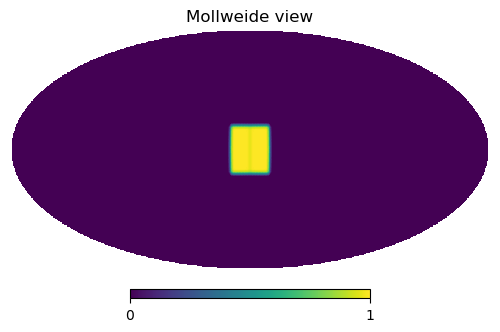

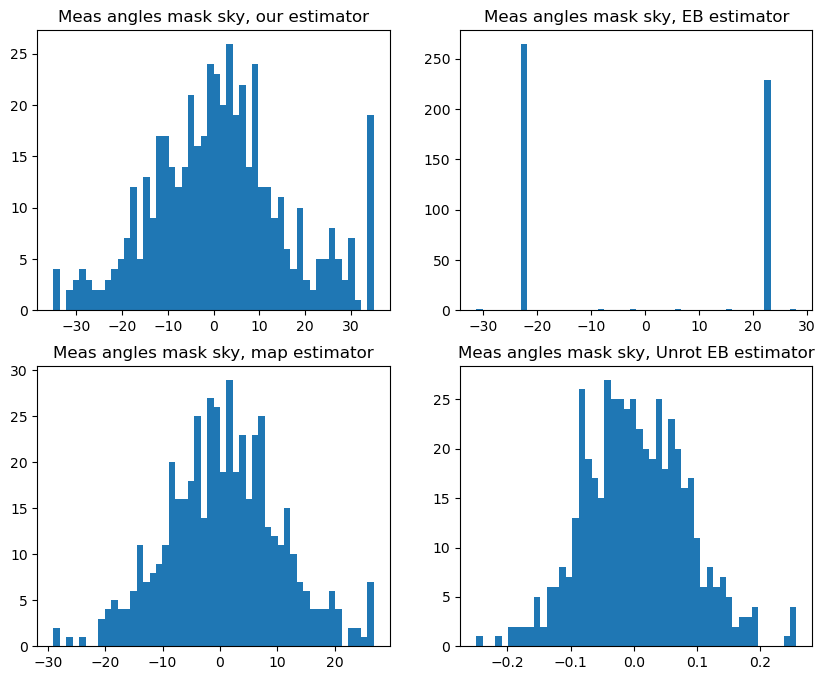

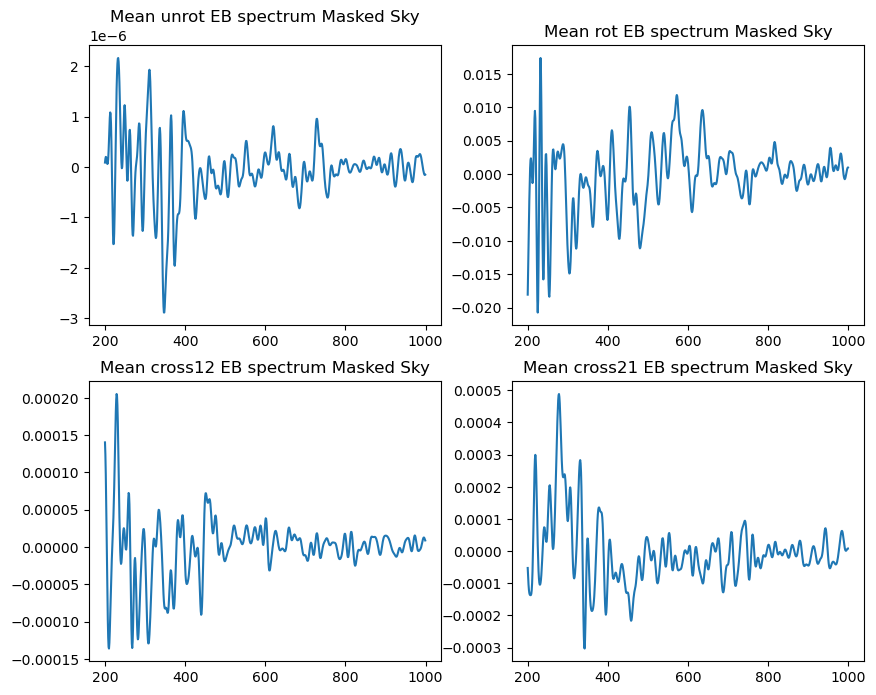

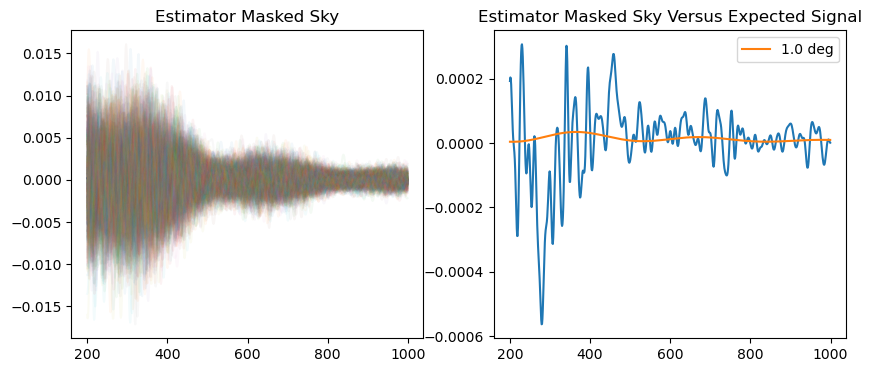

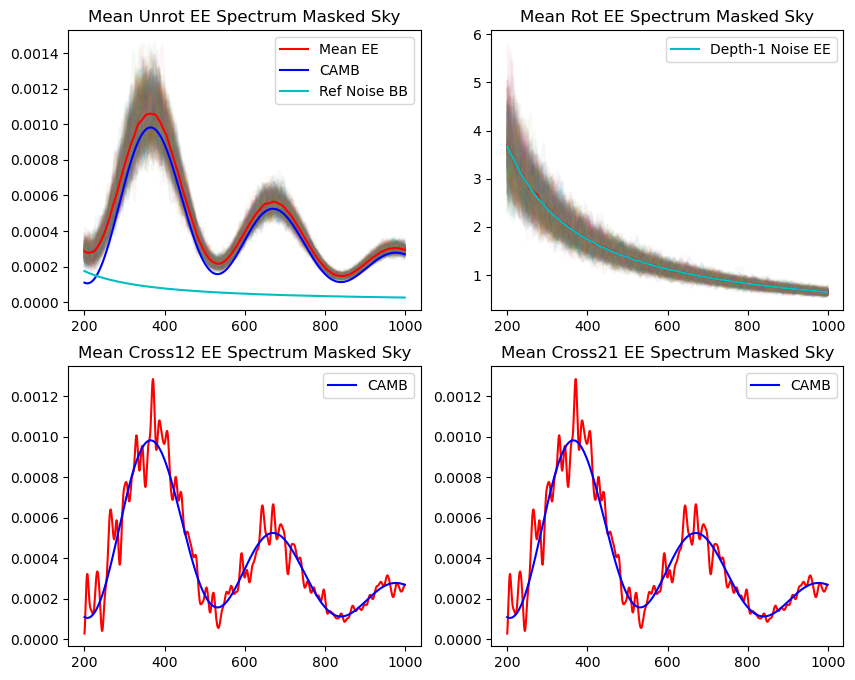

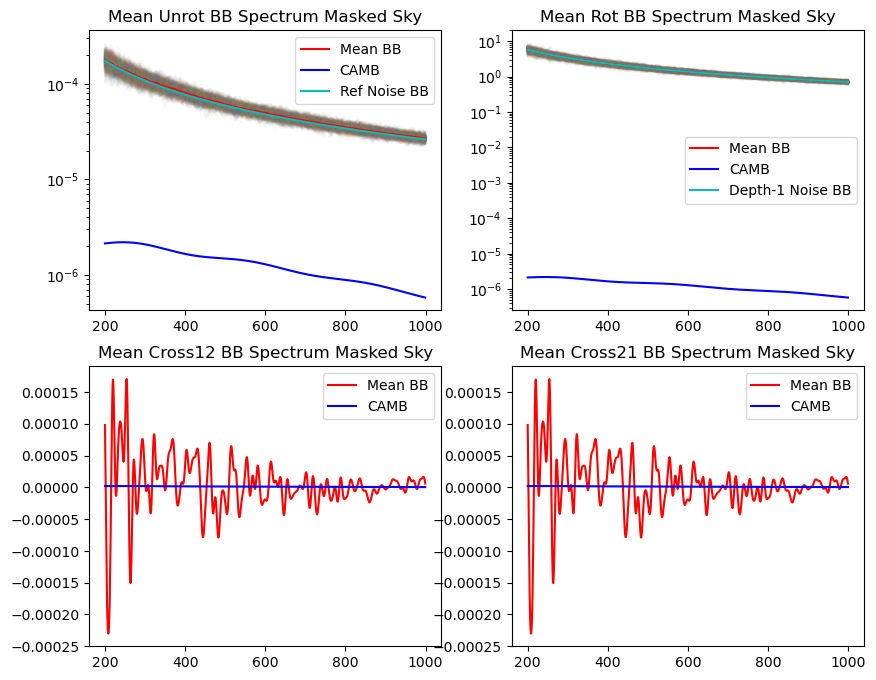

In [19]:
run_masked_healpix_sims(nside=512, N_sims=500, rot_angle=1.0, mask_ra=[-15,15], mask_dec=[15,-15],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)

6.870972823634812
RA crossing 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:44:05<00:00, 19.69s/it]


N_sims = 500, Injected angle =0.1, Mask size (ra/dec): [-15, 15] [15, -15]
Median angle, our estimator: 0.11585115851158889
Mean angle, our estimator: -0.22922989229892074
Std dev angle, our estimator: 14.946040749485515
Median angle, map based estimator: 0.38377460032068367
Mean angle, map based estimator: 0.008872443653631535
Std dev angle, map based estimator: 9.658424462473363
Mean angle, EB estimator: 0.26942009420094576
Mean angle, unrot EB estimator: 0.0015201520152015888


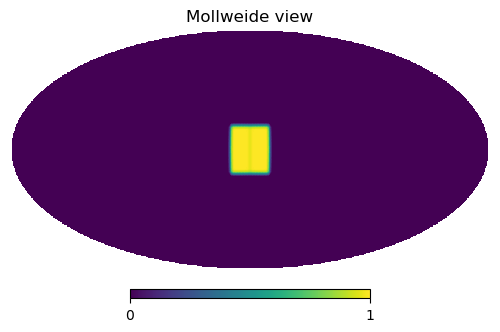

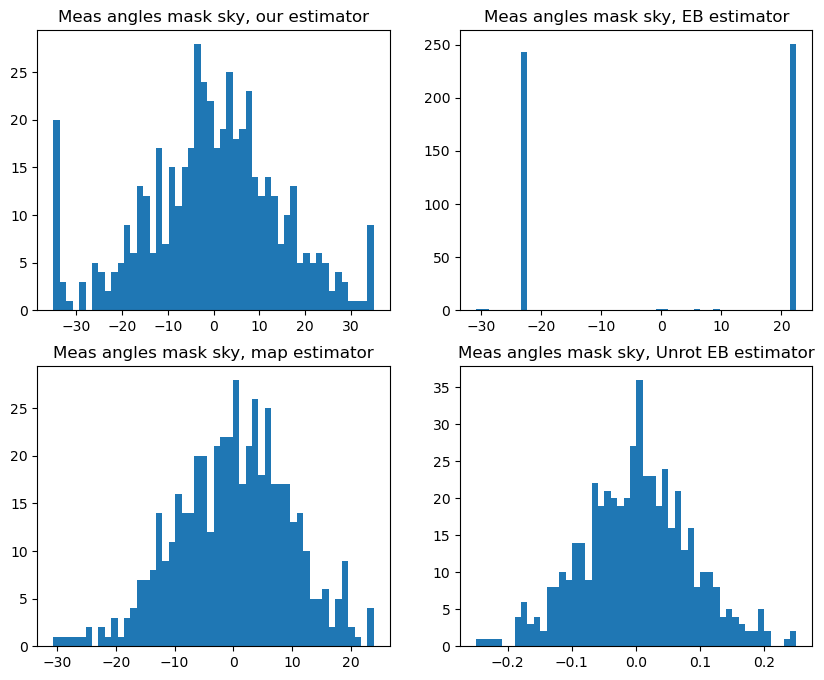

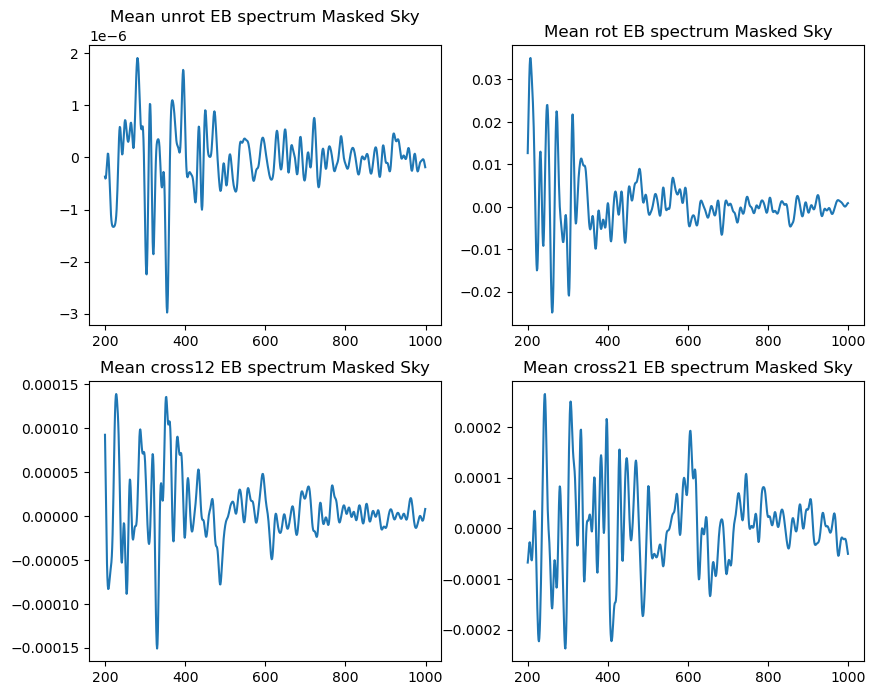

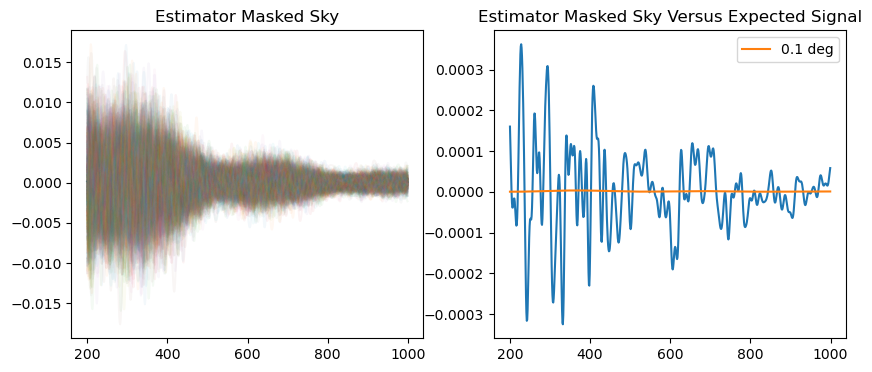

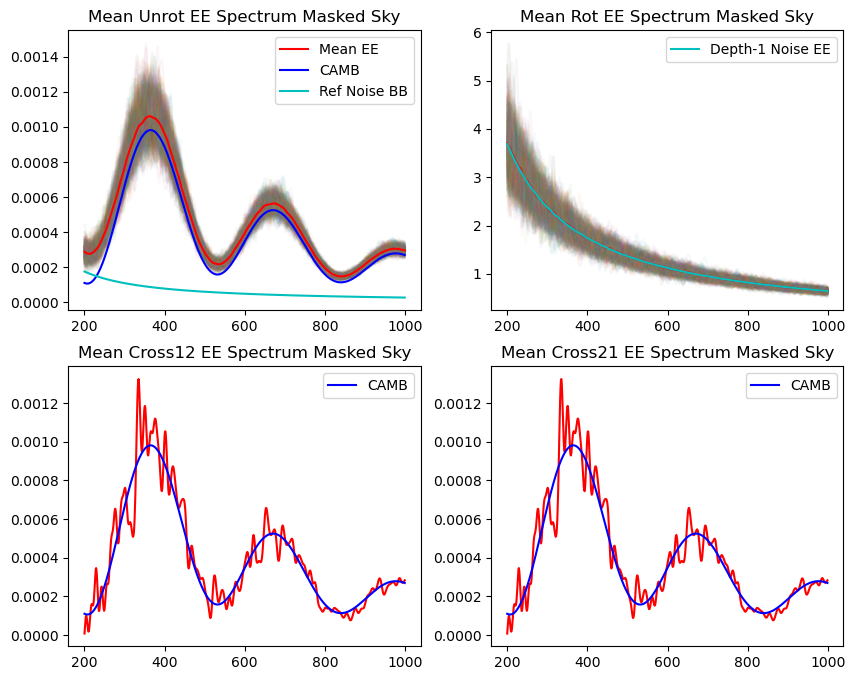

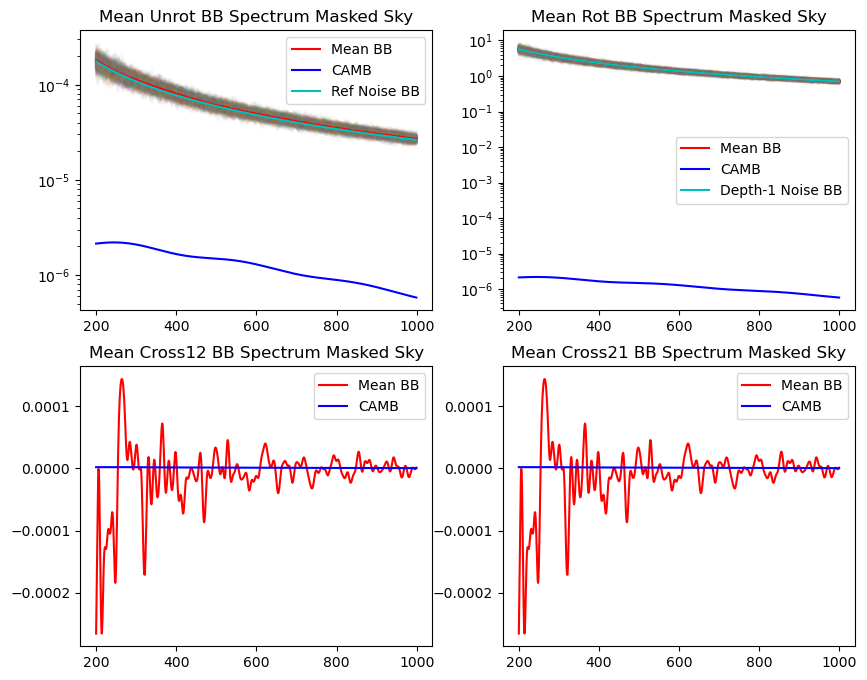

In [20]:
run_masked_healpix_sims(nside=512, N_sims=500, rot_angle=0.1, mask_ra=[-15,15], mask_dec=[15,-15],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)

6.870972823634812
RA crossing 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:38:53<00:00, 19.07s/it]


N_sims = 500, Injected angle =5.0, Mask size (ra/dec): [-15, 15] [15, -15]
Median angle, our estimator: 4.527995279952805
Mean angle, our estimator: 5.9383875838758415
Std dev angle, our estimator: 13.852600188017941
Median angle, map based estimator: 3.7930419937762956
Mean angle, map based estimator: 3.74060791051026
Std dev angle, map based estimator: 9.421337240580197
Mean angle, EB estimator: -0.9673676736767333
Mean angle, unrot EB estimator: 0.004152415241524232


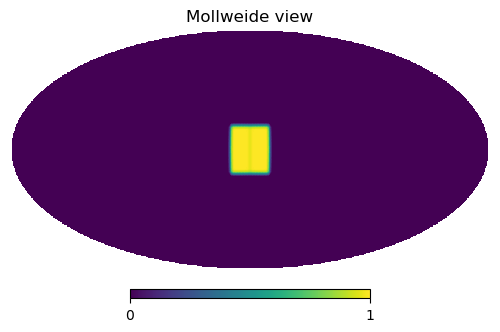

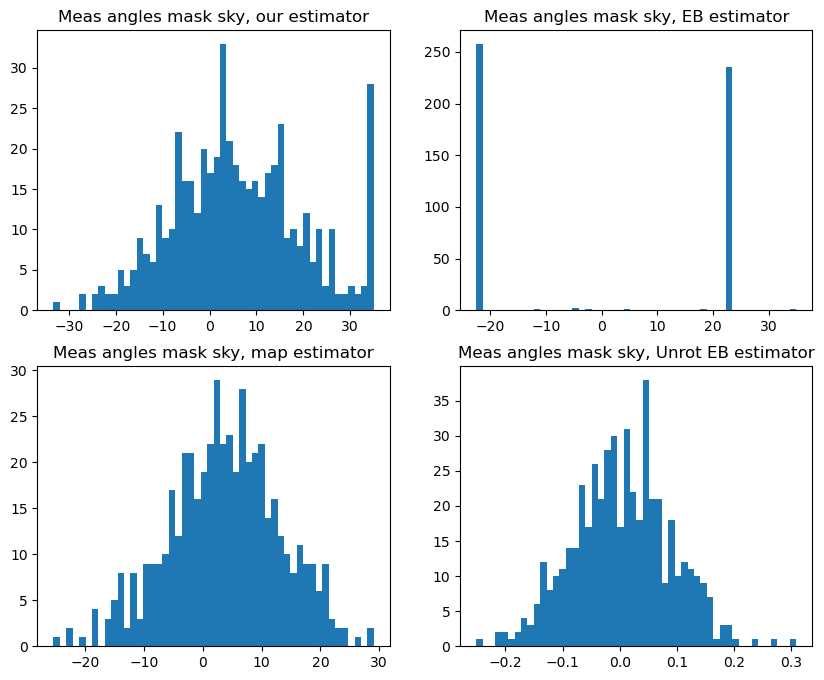

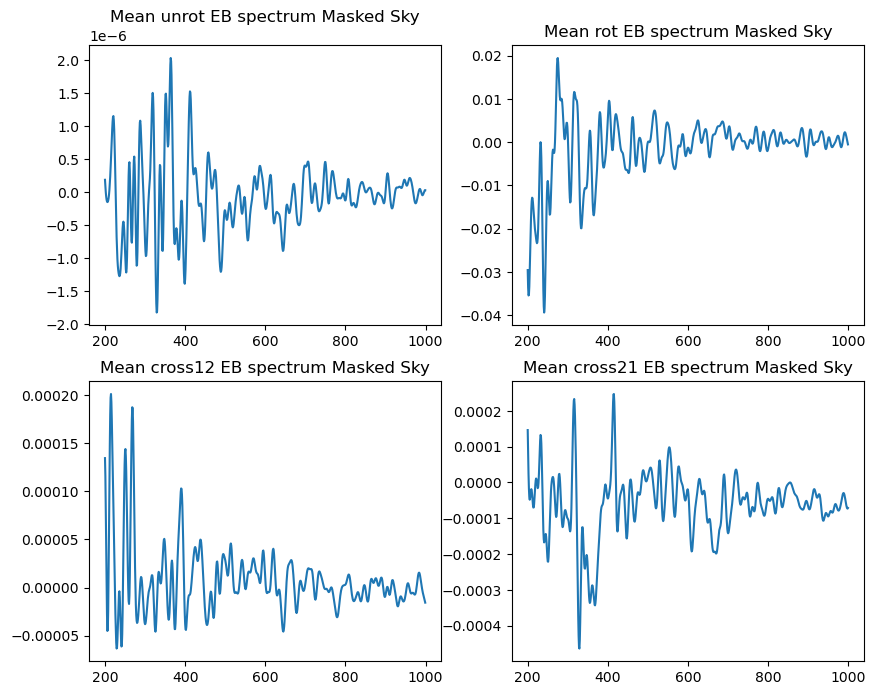

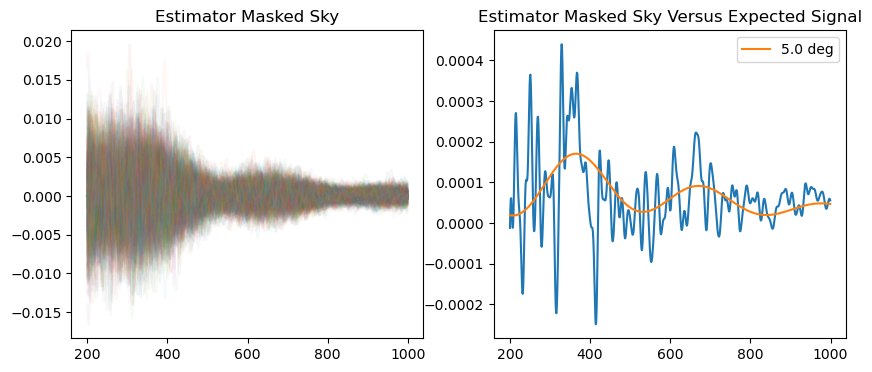

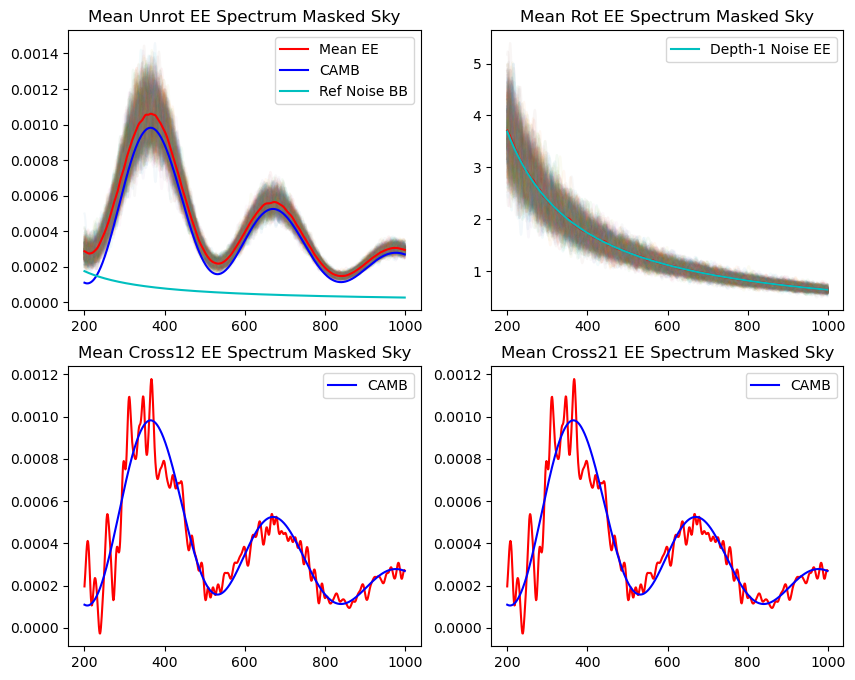

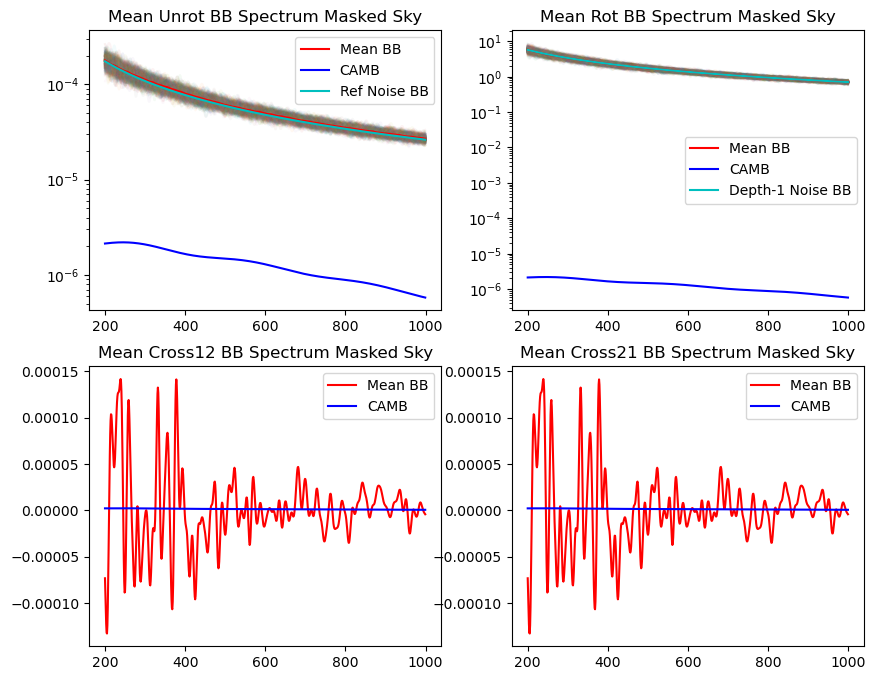

In [21]:
run_masked_healpix_sims(nside=512, N_sims=500, rot_angle=5.0, mask_ra=[-15,15], mask_dec=[15,-15],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)

6.870972823634812
RA crossing 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:09:57<00:00, 18.60s/it]


N_sims = 1000, Injected angle =0.1, Mask size (ra/dec): [-5, 5] [5, -5]
Median angle, our estimator: 0.47670476704767495
Mean angle, our estimator: 0.9680032800328014
Std dev angle, our estimator: 27.09996287352352
Median angle, map based estimator: -0.3971369555026316
Mean angle, map based estimator: 0.4315895011709587
Std dev angle, map based estimator: 32.04547344049809
Mean angle, EB estimator: 0.22087390873909113
Mean angle, unrot EB estimator: 0.004628462846284698


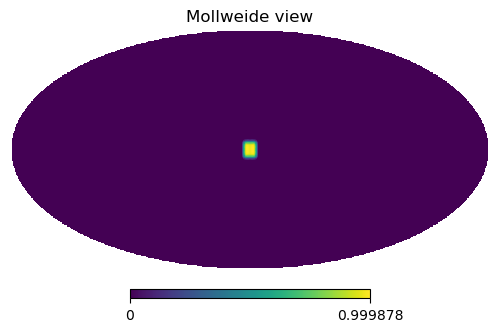

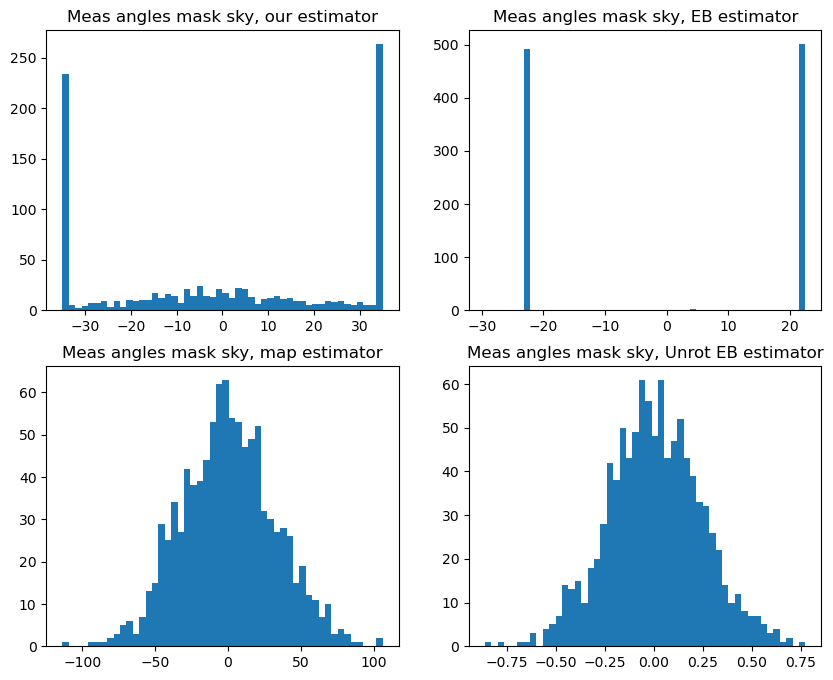

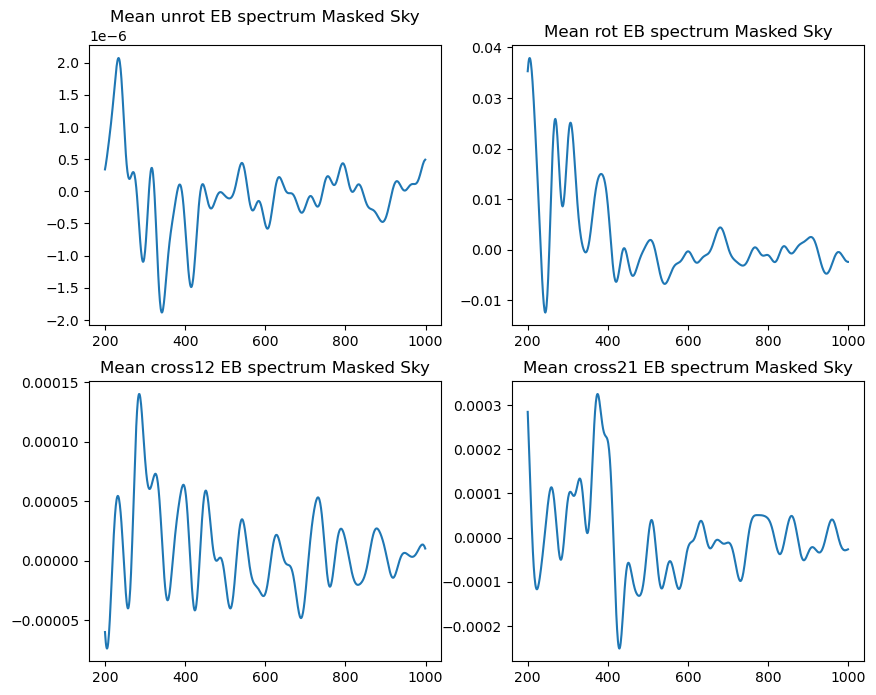

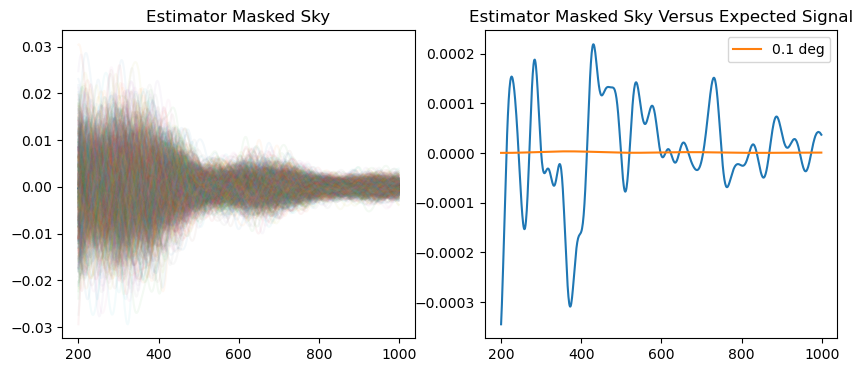

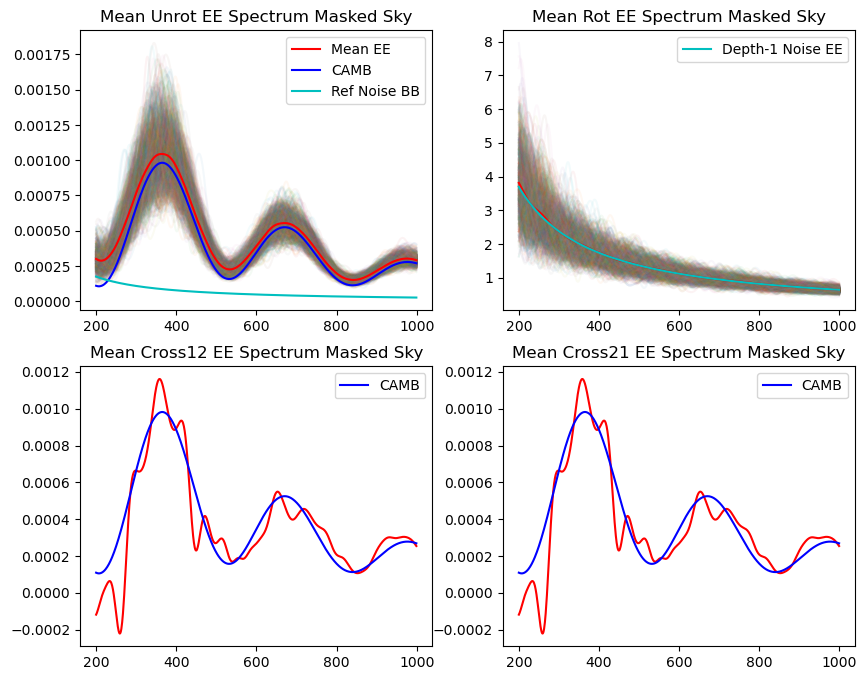

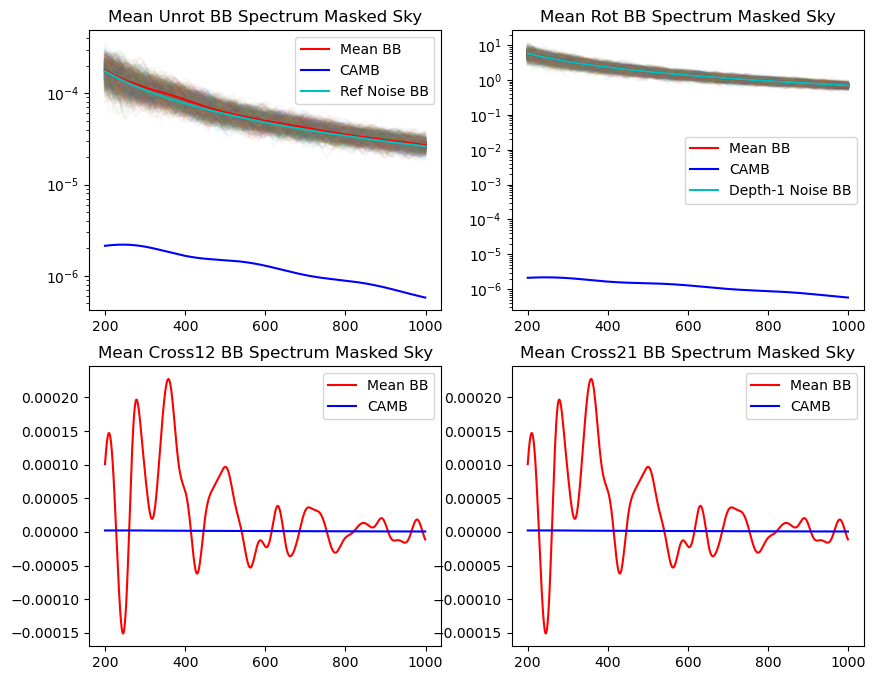

In [22]:
# Smaller 10x10 deg mask, more sims
run_masked_healpix_sims(nside=512, N_sims=1000, rot_angle=0.1, mask_ra=[-5,5], mask_dec=[5,-5],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)

6.870972823634812
RA crossing 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:06:49<00:00, 18.41s/it]


N_sims = 1000, Injected angle =1.0, Mask size (ra/dec): [-5, 5] [5, -5]
Median angle, our estimator: 0.5383053830538351
Mean angle, our estimator: -0.23640636406363932
Std dev angle, our estimator: 27.474307708424636
Median angle, map based estimator: -0.15725124139273824
Mean angle, map based estimator: -0.8312833065989953
Std dev angle, map based estimator: 30.724544365493934
Mean angle, EB estimator: 1.194484244842452
Mean angle, unrot EB estimator: 0.004616461646164694


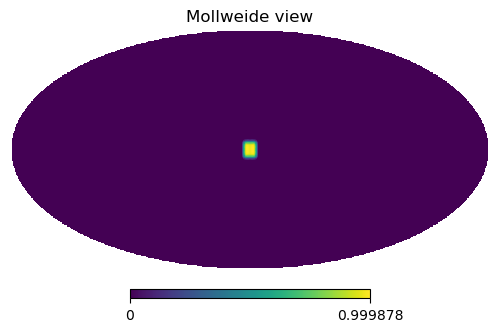

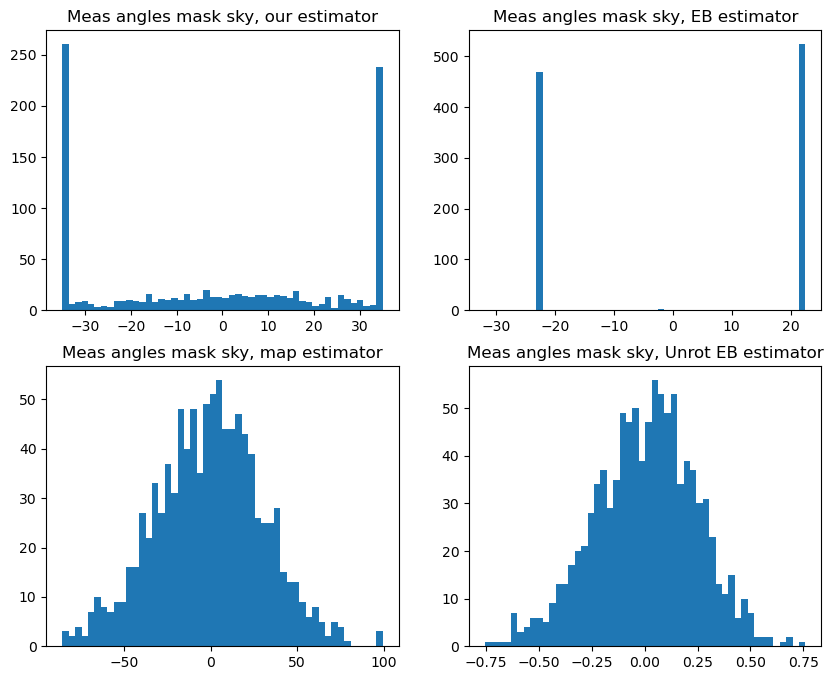

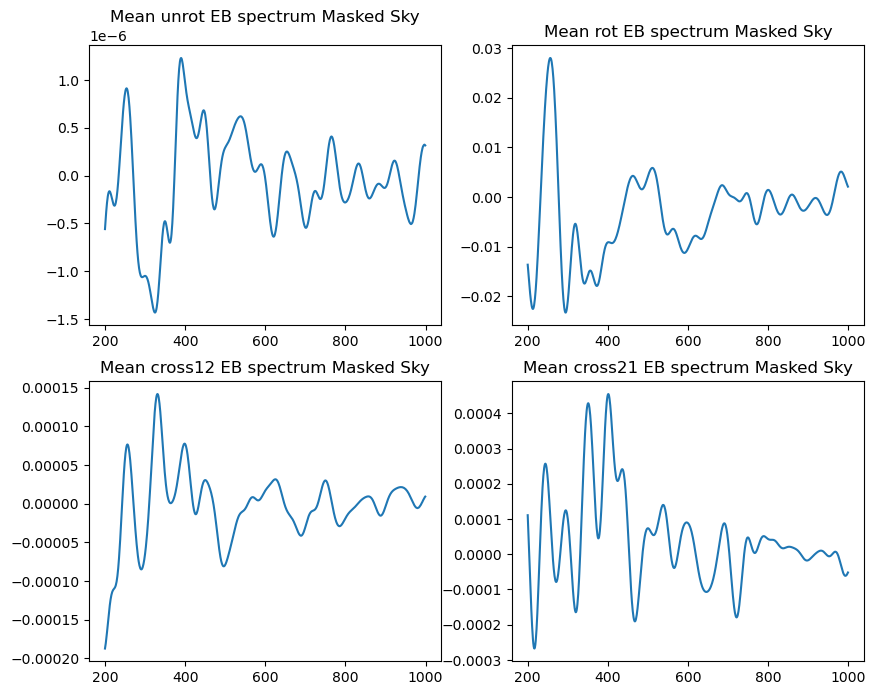

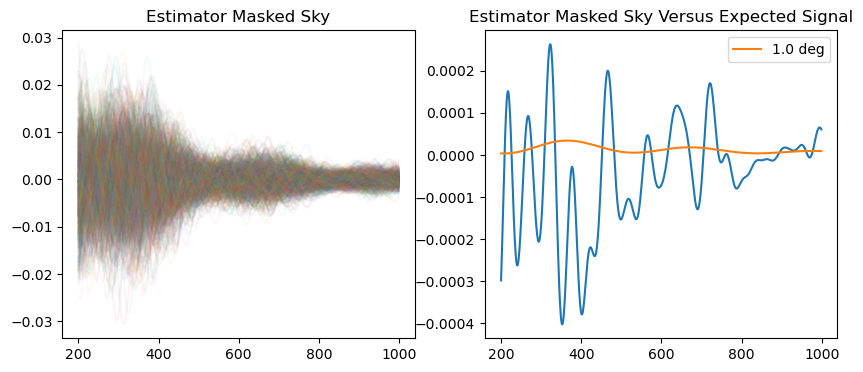

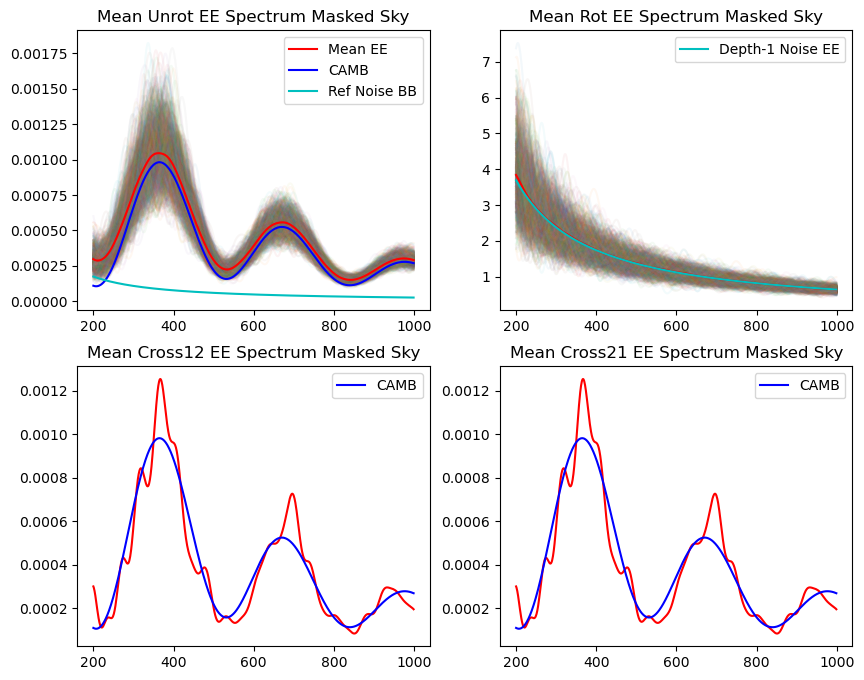

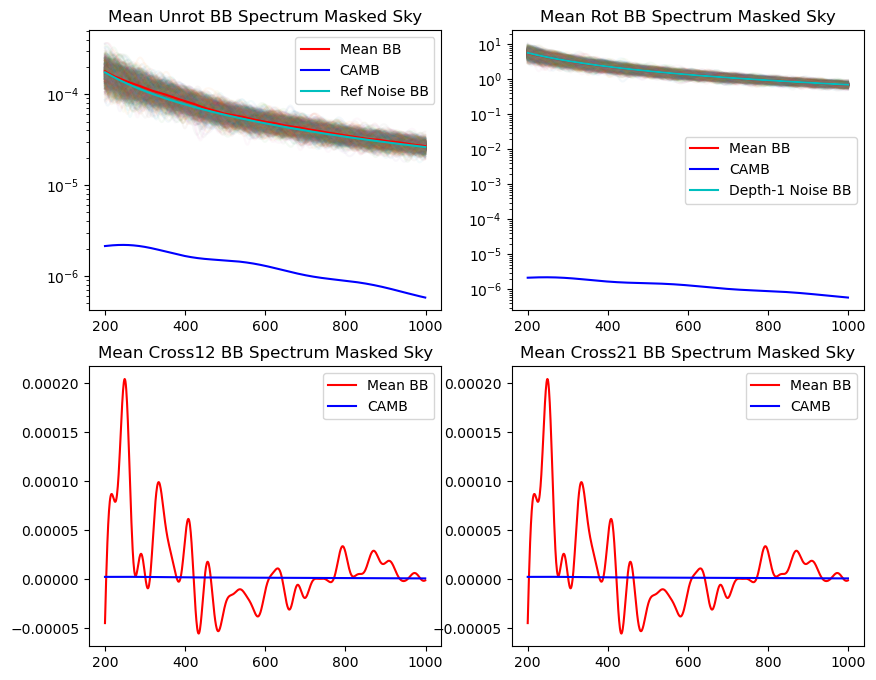

In [23]:
# Smaller 10x10 deg mask, more sims
run_masked_healpix_sims(nside=512, N_sims=1000, rot_angle=1.0, mask_ra=[-5,5], mask_dec=[5,-5],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)

6.870972823634812
RA crossing 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:05:33<00:00, 18.33s/it]


N_sims = 1000, Injected angle =5.0, Mask size (ra/dec): [-5, 5] [5, -5]
Median angle, our estimator: 2.3926239262392635
Mean angle, our estimator: 1.729837698376985
Std dev angle, our estimator: 27.807867031254172
Median angle, map based estimator: 2.475596313580084
Mean angle, map based estimator: 3.627042443788513
Std dev angle, map based estimator: 30.488433684455877
Mean angle, EB estimator: 1.5260481604816087
Mean angle, unrot EB estimator: 0.003258325832583331


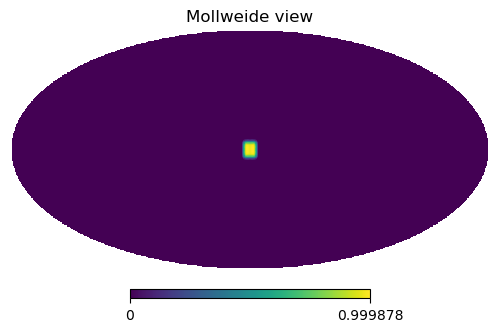

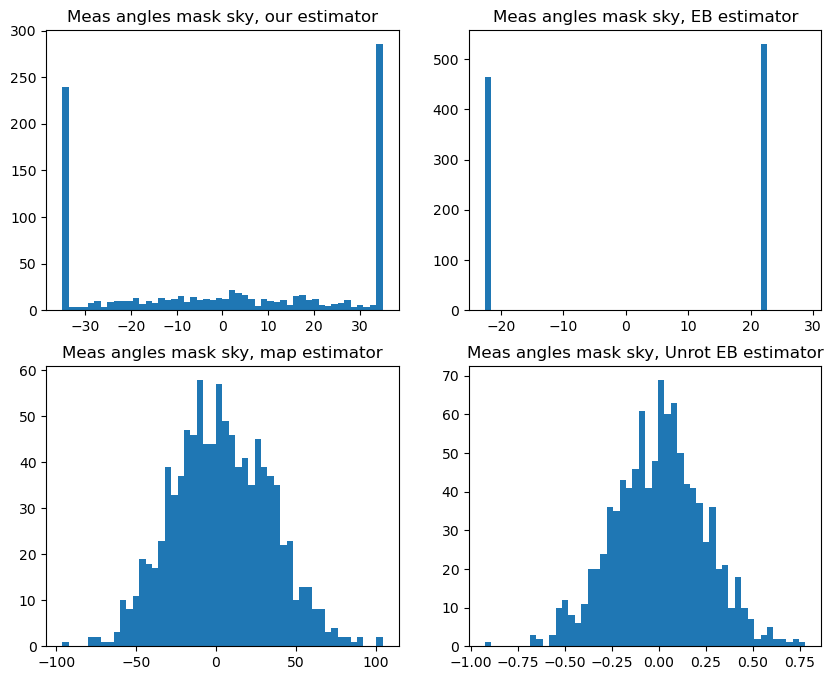

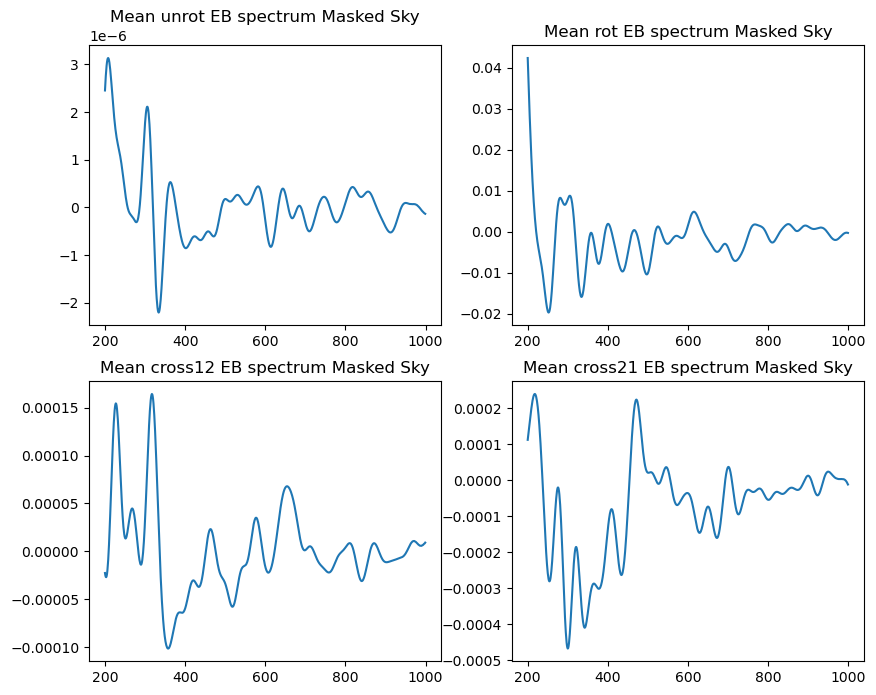

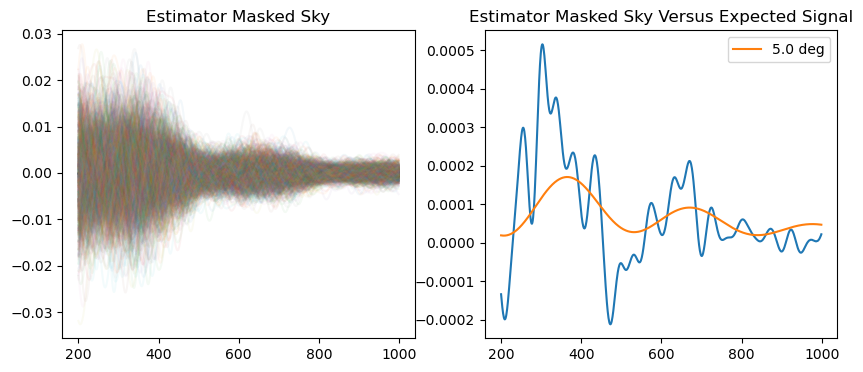

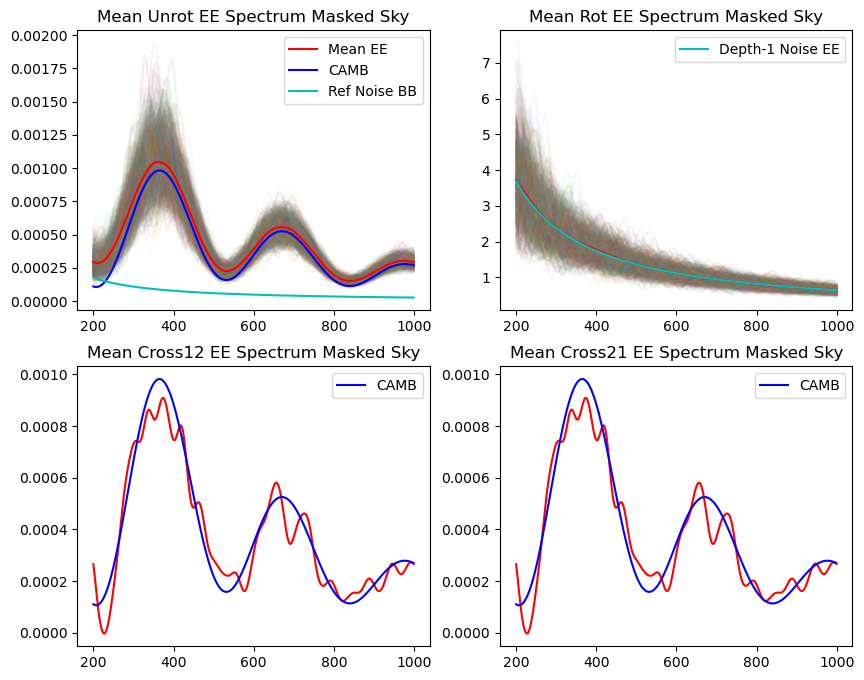

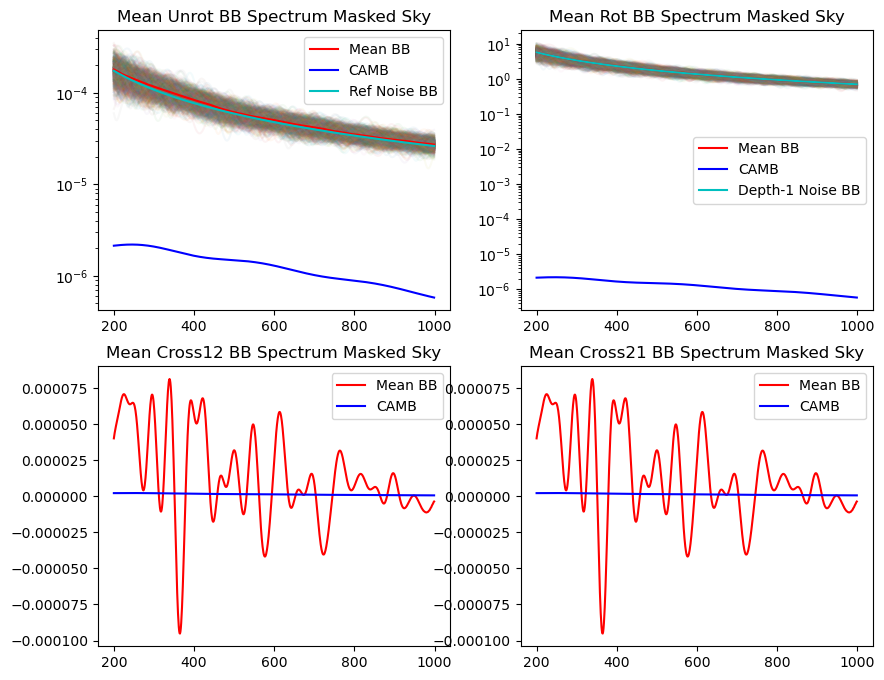

In [24]:
# Smaller 10x10 deg mask, more sims
run_masked_healpix_sims(nside=512, N_sims=1000, rot_angle=5.0, mask_ra=[-5,5], mask_dec=[5,-5],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)

6.870972823634812
RA crossing 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:07:01<00:00, 18.42s/it]


N_sims = 1000, Injected angle =0.1, Mask size (ra/dec): [-1, 1] [1, -1]
Median angle, our estimator: -1.551915519155191
Mean angle, our estimator: 0.07119491194912007
Std dev angle, our estimator: 32.62214876588738
Median angle, map based estimator: 4.306497826179869
Mean angle, map based estimator: -1.2135077623548005
Std dev angle, map based estimator: 112.86481183895106
Mean angle, EB estimator: -0.4169017690176865
Mean angle, unrot EB estimator: -0.026748674867486697


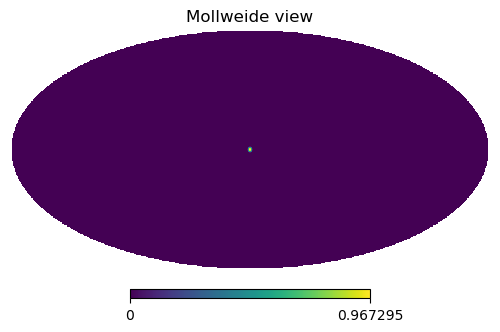

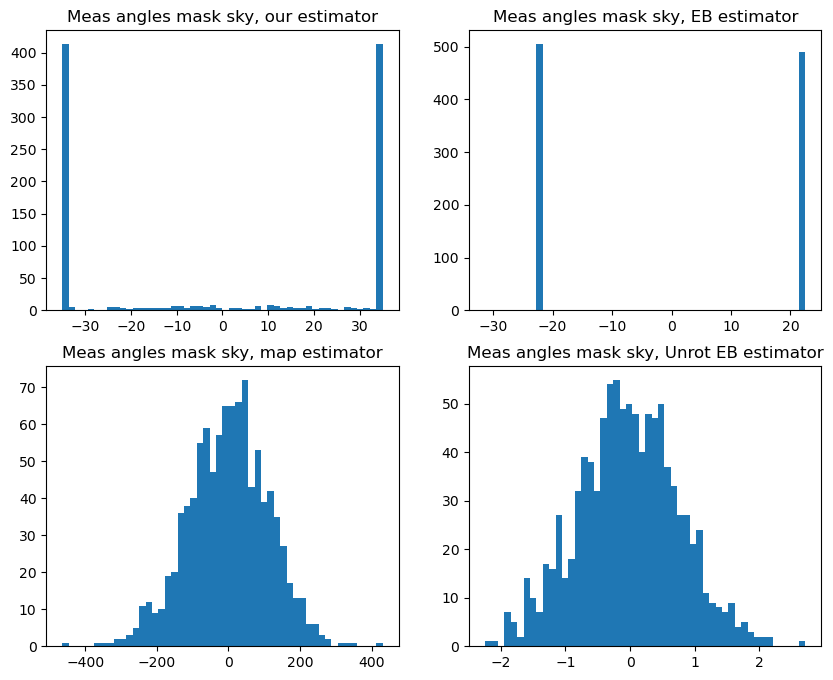

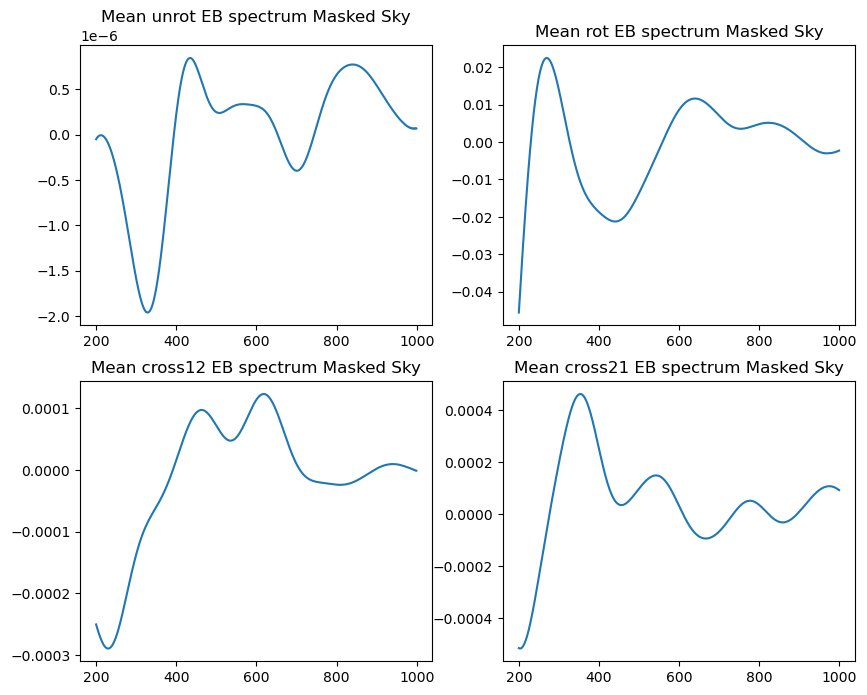

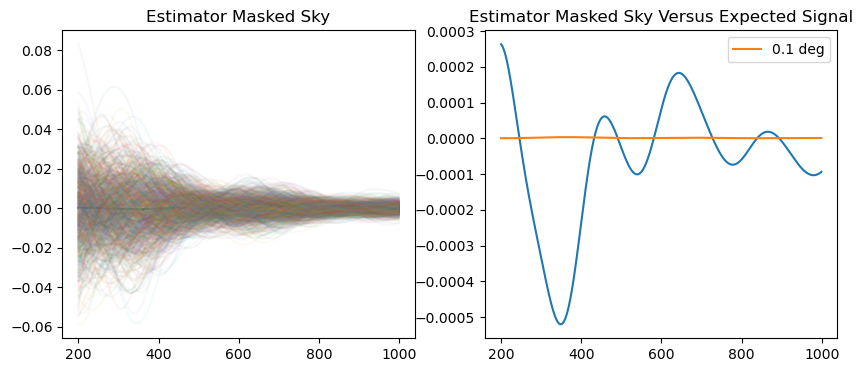

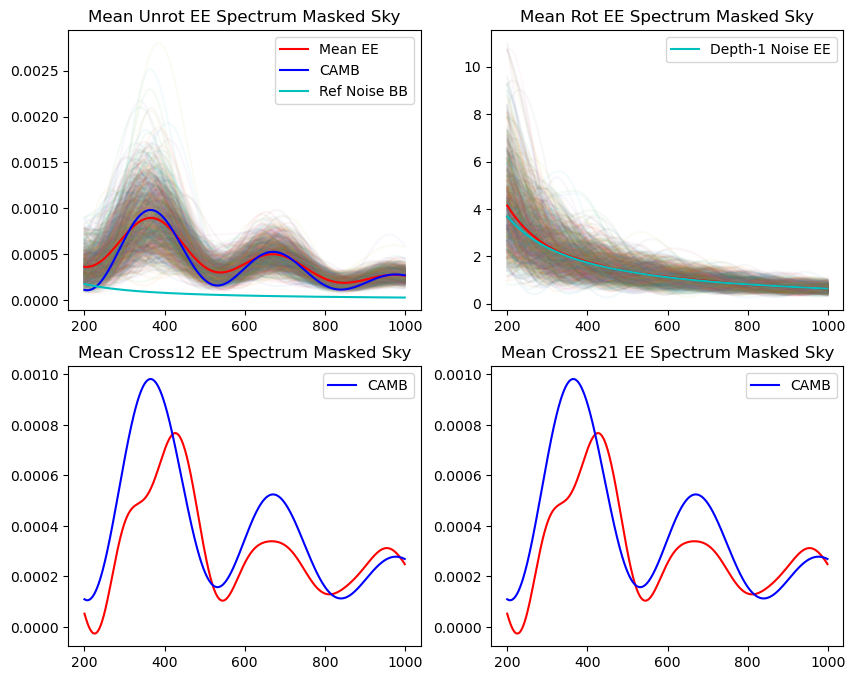

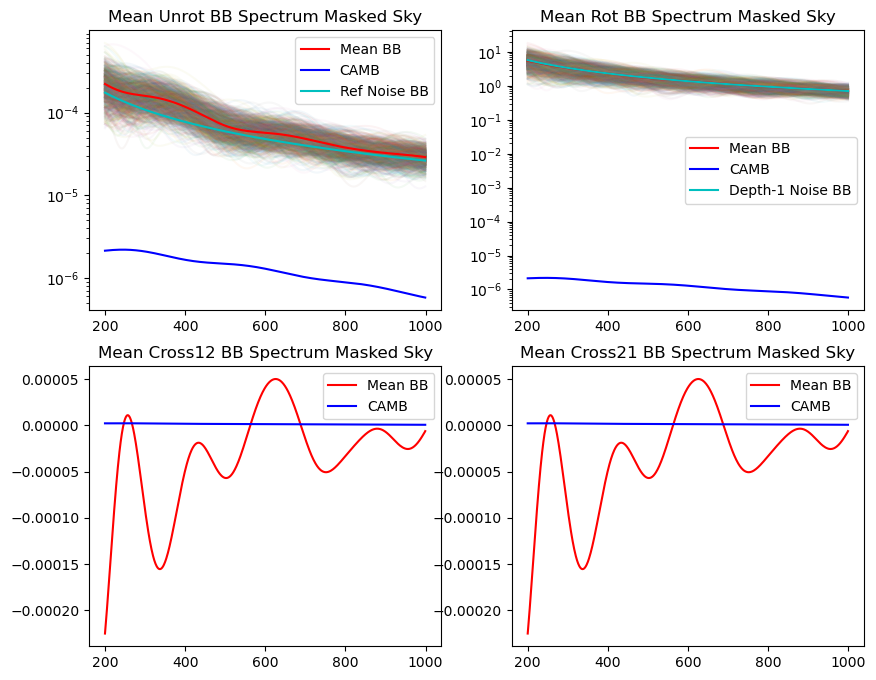

In [25]:
# Smaller 2x2 deg mask, more sims
run_masked_healpix_sims(nside=512, N_sims=1000, rot_angle=0.1, mask_ra=[-1,1], mask_dec=[1,-1],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)

6.870972823634812
RA crossing 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:04:23<00:00, 18.26s/it]


N_sims = 1000, Injected angle =1.0, Mask size (ra/dec): [-1, 1] [1, -1]
Median angle, our estimator: 1.2638626386263923
Mean angle, our estimator: -0.18303153031530286
Std dev angle, our estimator: 32.62853793532391
Median angle, map based estimator: 4.108581338835794
Mean angle, map based estimator: 1.933914774936306
Std dev angle, map based estimator: 111.24710313429328
Mean angle, EB estimator: 1.2795000950009539
Mean angle, unrot EB estimator: -0.036845684568456764


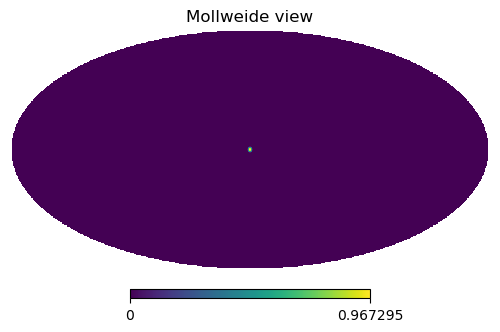

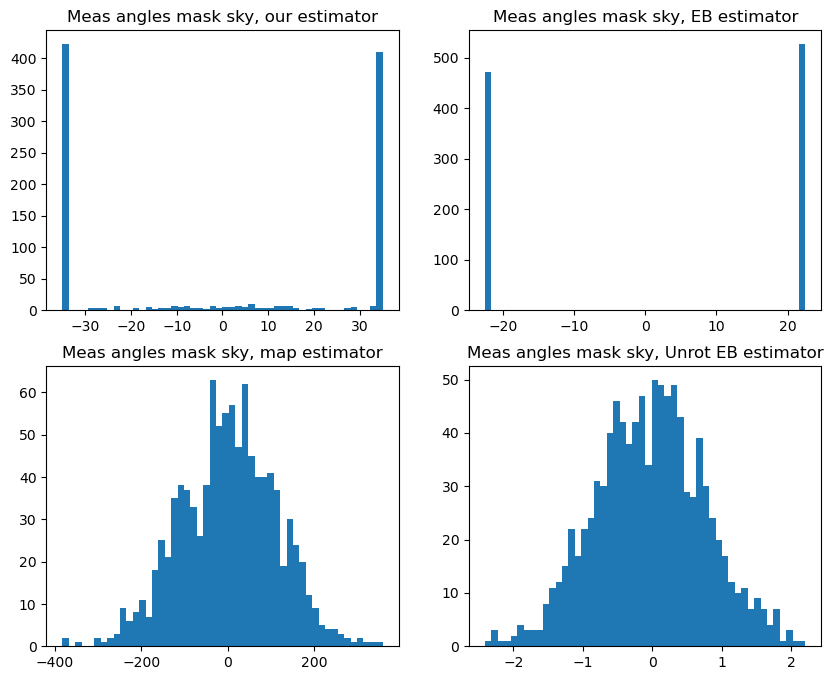

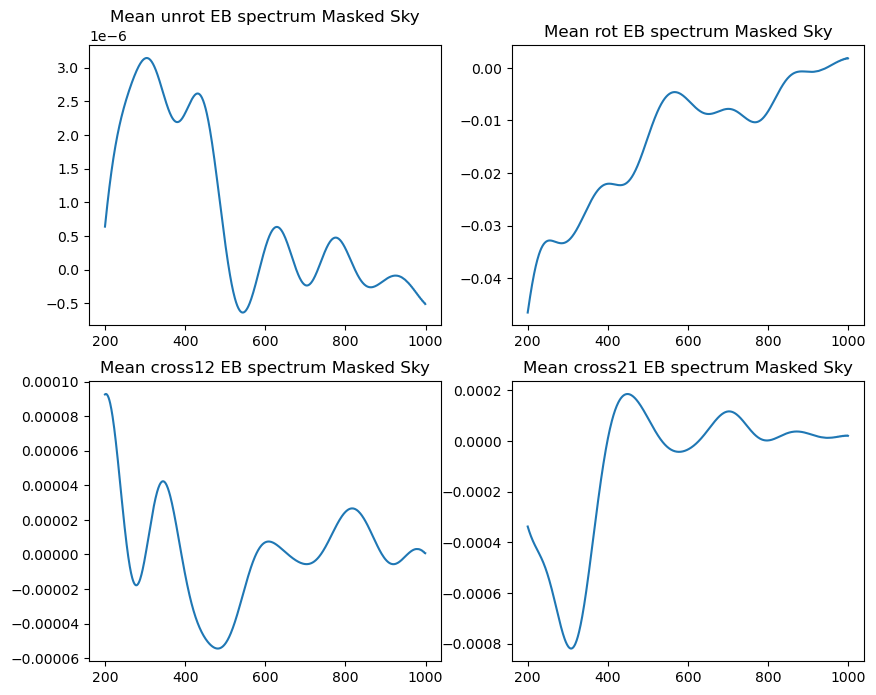

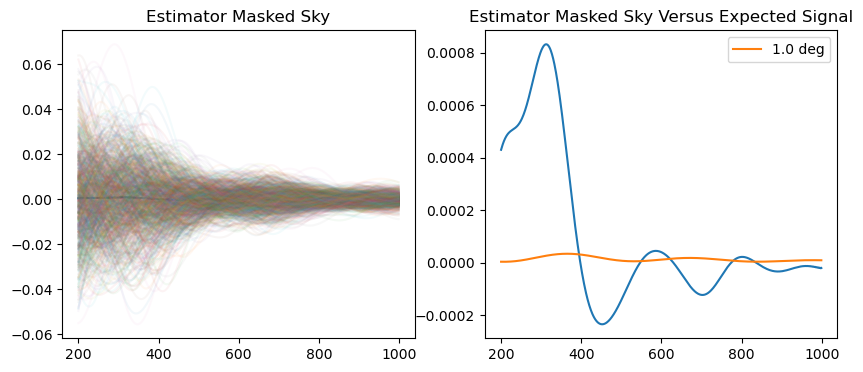

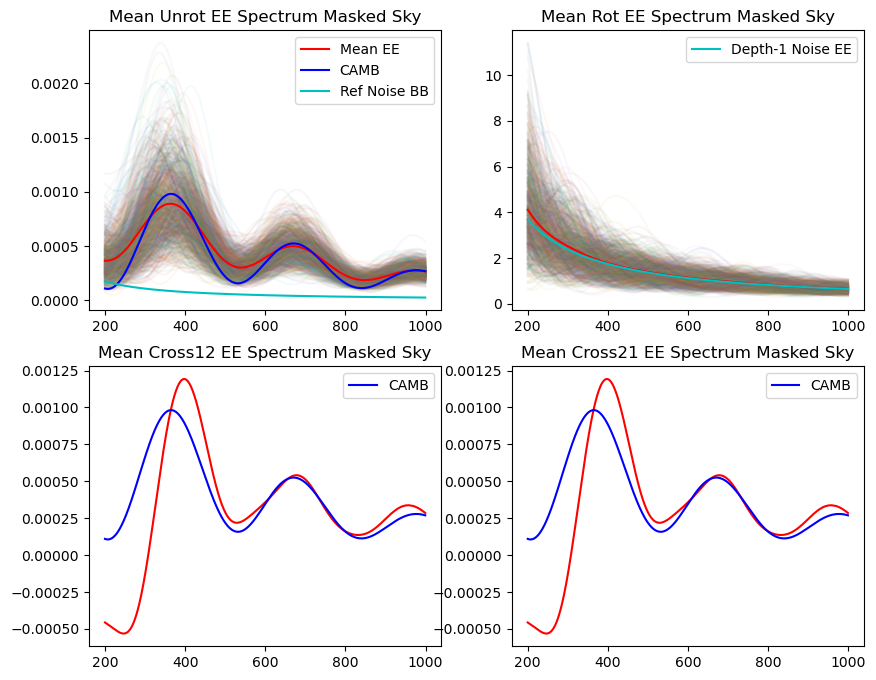

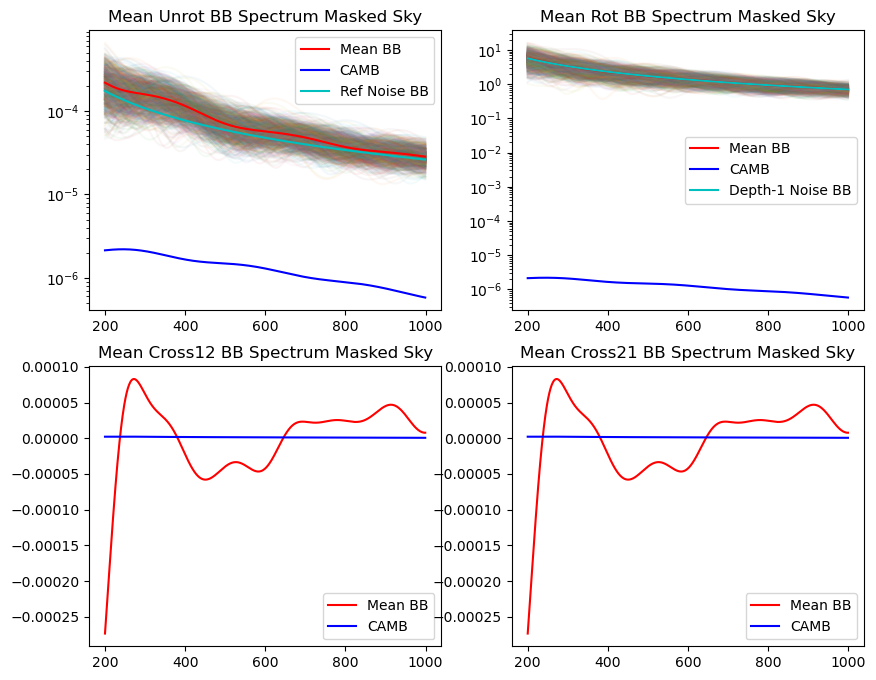

In [26]:
# Smaller 2x2 deg mask, more sims
run_masked_healpix_sims(nside=512, N_sims=1000, rot_angle=1.0, mask_ra=[-1,1], mask_dec=[1,-1],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)

6.870972823634812
RA crossing 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:03:21<00:00, 18.20s/it]


N_sims = 1000, Injected angle =5.0, Mask size (ra/dec): [-1, 1] [1, -1]
Median angle, our estimator: -0.33635336353363243
Mean angle, our estimator: -0.17170121701216984
Std dev angle, our estimator: 32.98444205824649
Median angle, map based estimator: -4.336162777335001
Mean angle, map based estimator: 0.7556744796067398
Std dev angle, map based estimator: 116.33345933131358
Mean angle, EB estimator: 0.8099990999910036
Mean angle, unrot EB estimator: -0.04369436943694362


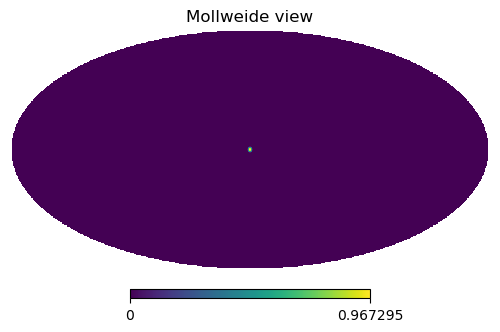

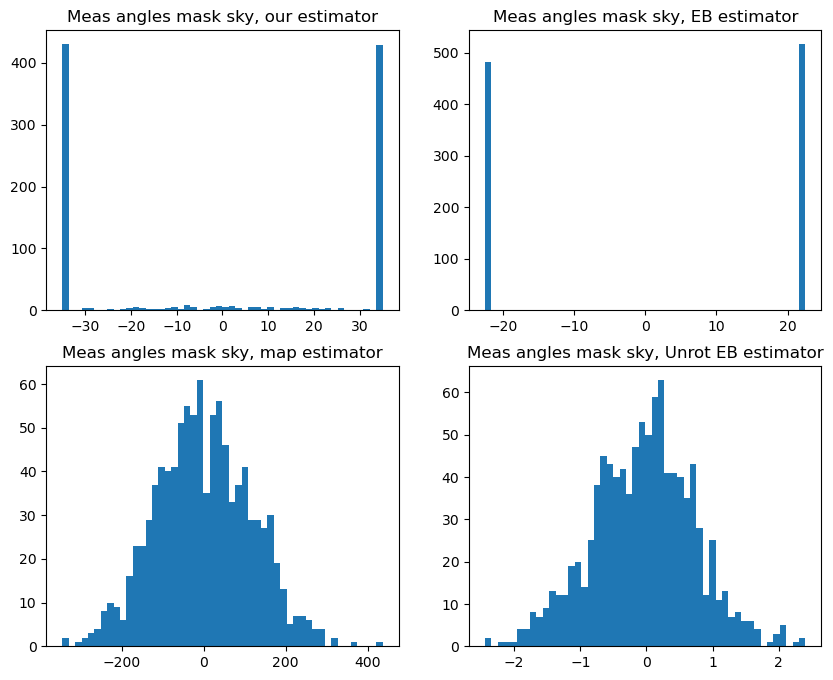

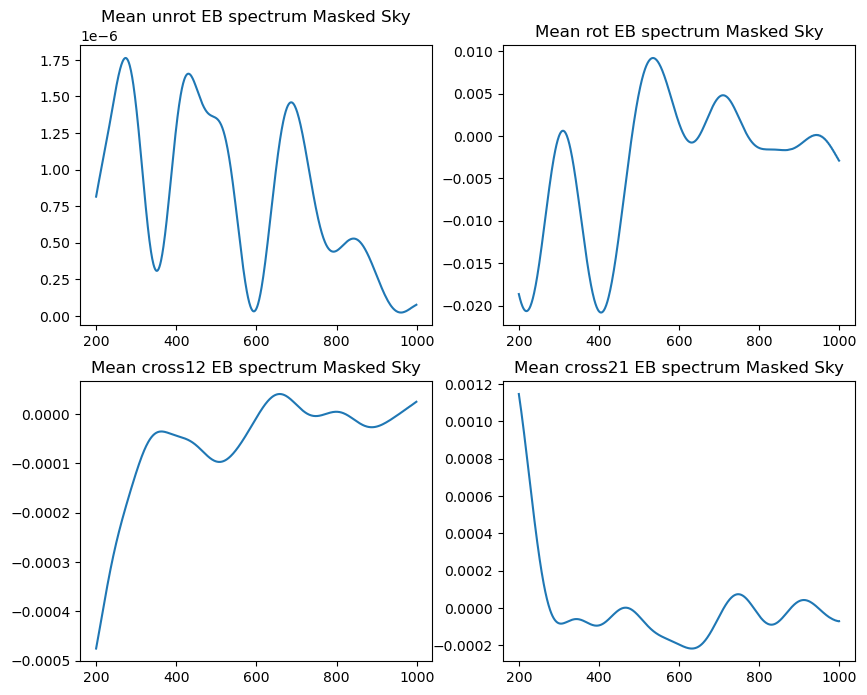

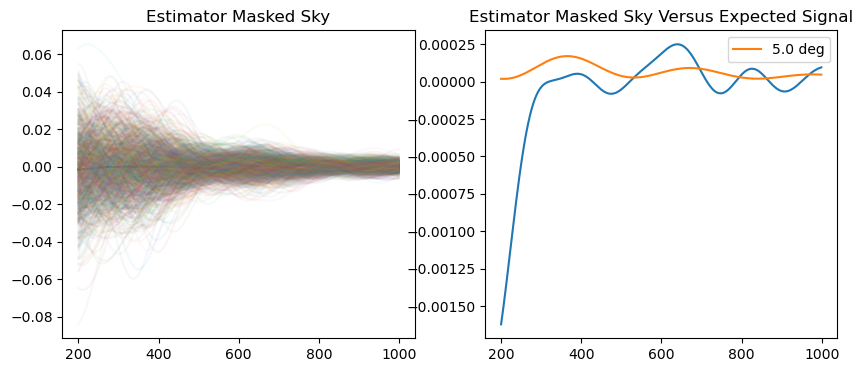

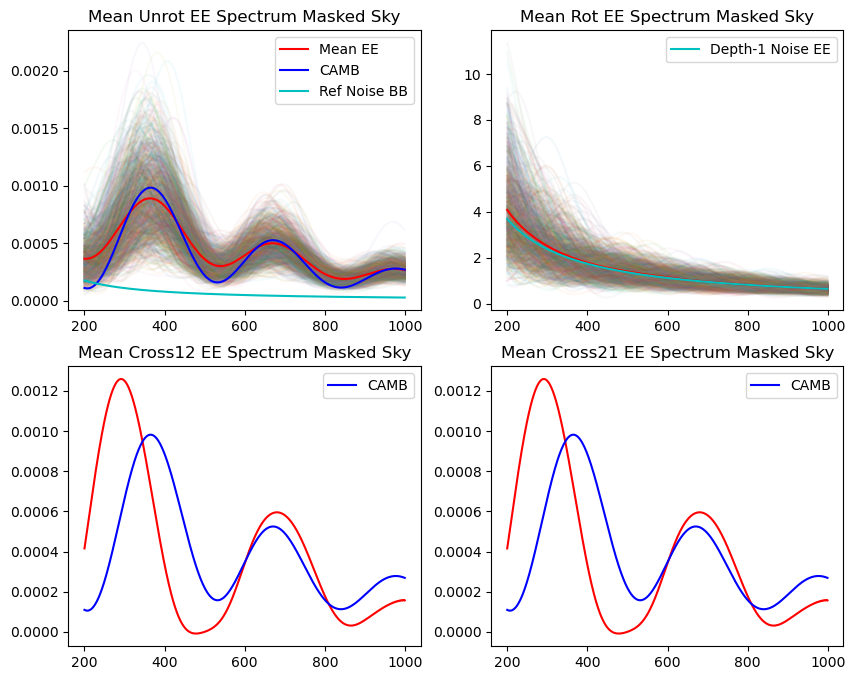

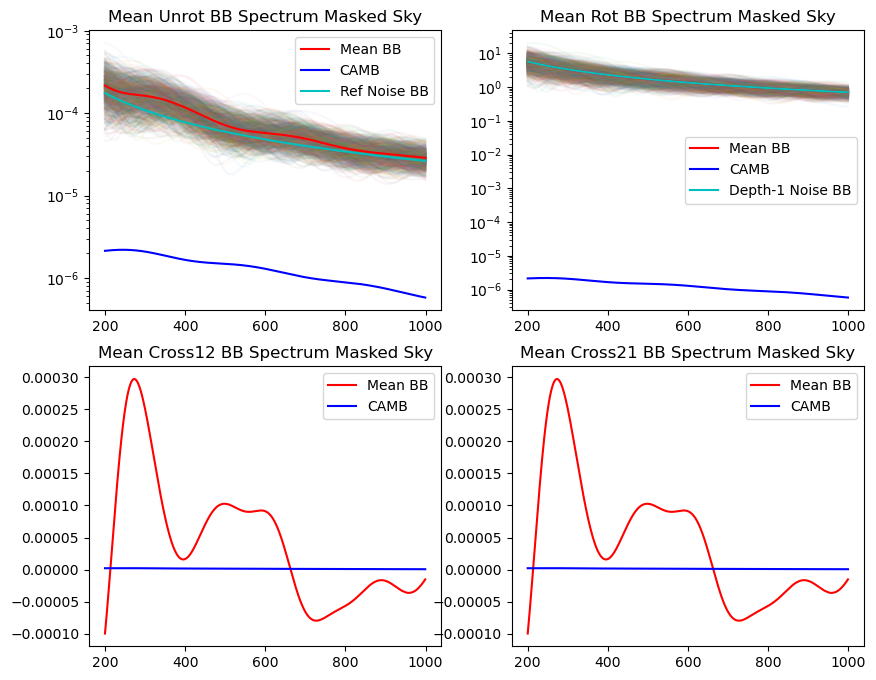

In [27]:
# Smaller 2x2 deg mask, more sims
run_masked_healpix_sims(nside=512, N_sims=1000, rot_angle=5.0, mask_ra=[-1,1], mask_dec=[1,-1],
                        start_fit_range_deg=-35.0, stop_fit_range_deg=35.0)